<a href="https://colab.research.google.com/github/micaelaillanessanchez-debug/Operational-REsearch-Project-/blob/main/operational_research_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
from datetime import datetime, timedelta

%pip install cdsapi
%pip install netcdf4
%pip install cartopy

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 23.4 MB/s eta 0:00:00


In [ ]:
# Inicializa a API do CDS com verificação SSL desativada
client = cdsapi.Client(url='https://ads.atmosphere.copernicus.eu/api', key='56ff124d-08b8-4fe3-a524-e45272516d72', verify=False)

dataset = "cams-gridded-solar-radiation"
request = {
    "variable": ["global_horizontal_irradiation"],
    "sky_type": ["clear"],
    "version": ["4.6"],
    "year": ["2022"],
    "month": [
        "01"
    ],
    "area": [51.0, -5, 42.0, 8.0]

}
client.retrieve(dataset, request).download()


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2026-01-15 09:00:23,270 INFO

a3413f0273dcbd9c7e78481d52dd5a80.zip:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'object-store.os-api.cci2.ecmwf.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


'a3413f0273dcbd9c7e78481d52dd5a80.zip'

In [ ]:
ds_GHI = xr.open_dataset('v4.6_GHI_clear_2022_01.area-subset.51.0.8.0.42.0.-5.nc', engine='h5netcdf')
df_converted_GHI = ds_GHI.to_dataframe()
df_converted_GHI

df_sum = (
    df_converted_GHI
    .groupby(["latitude", "longitude"])["global_horizontal_clear_sky_irradiation"]
    .sum()   # pas besoin de skipna
    .reset_index()
)

df_sum["GHI_energy_Wh_m2"] = (
    df_sum["global_horizontal_clear_sky_irradiation"] * 0.25
)

In [ ]:
# Créer une grille pivot : latitudes en index, longitudes en colonnes
ghi_grid = df_sum.pivot(
    index='latitude',
    columns='longitude',
    values='GHI_energy_Wh_m2'
)

# Trier les axes : longitudes croissantes, latitudes du Sud vers le Nord
ghi_grid = ghi_grid[sorted(ghi_grid.columns)]     # longitudes croissantes
ghi_grid = ghi_grid.sort_index(ascending=True)   # latitudes croissantes (Sud → Nord)

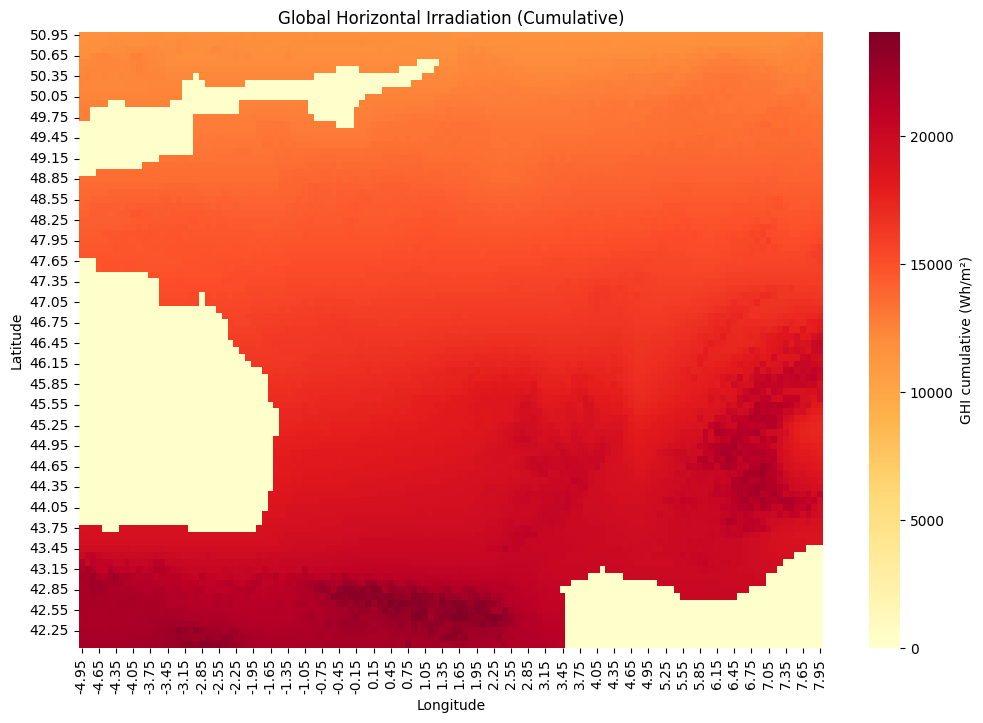

In [ ]:
# CODE POUR IRRADIATION HEAT MAP
plt.figure(figsize=(12,8))
sns.heatmap(
    ghi_grid[::-1],  # inverse les lignes pour que le Sud soit en bas
    cmap="YlOrRd",
    cbar_kws={'label': 'GHI cumulative (Wh/m²)'}
)
plt.title("Global Horizontal Irradiation (Cumulative)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


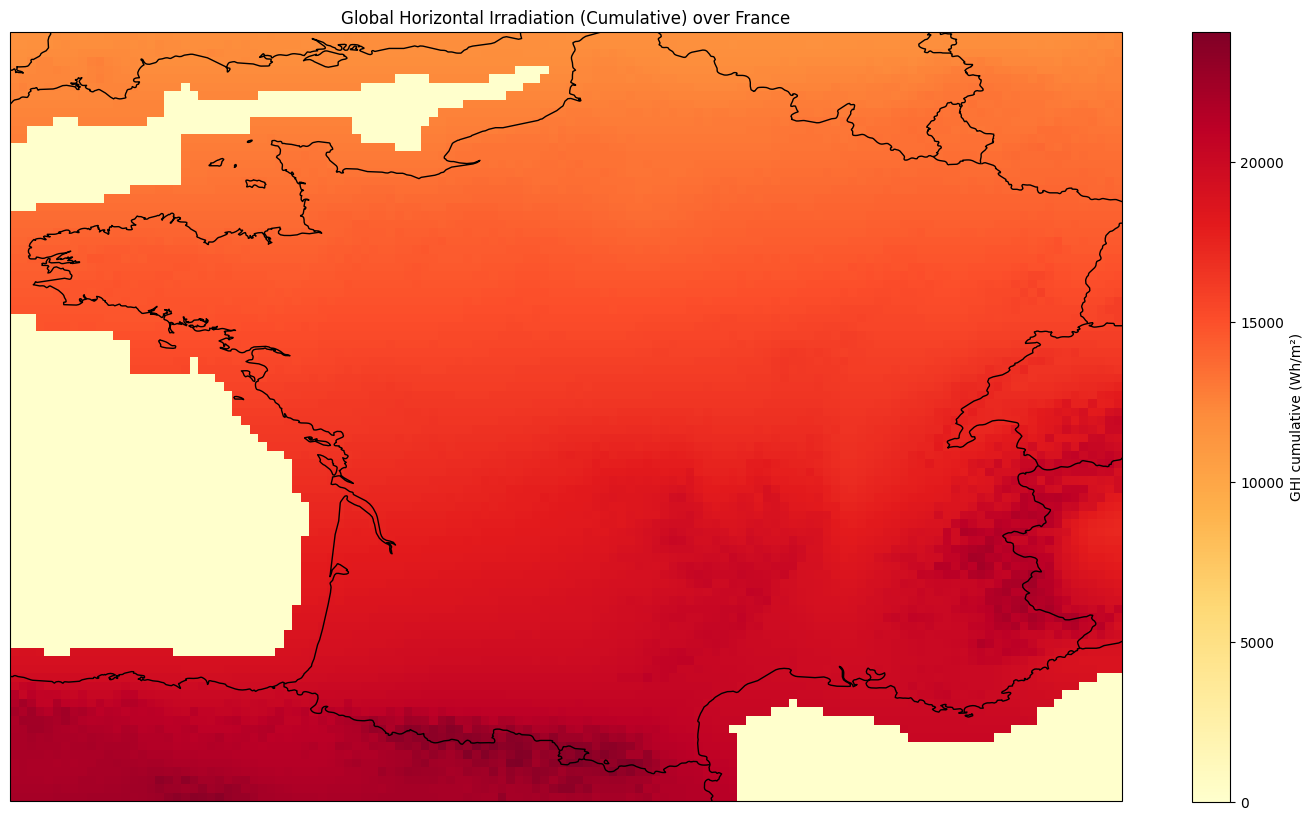

In [ ]:
# CODE POUR IRRADIATION HEATMAP + CARTE DES PAYS
# Zone CAMS
lat_min, lat_max = 42.0, 51.0
lon_min, lon_max = -5.0, 8.0

plt.figure(figsize=(18,10))

# Axe géographique Cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Ajouter carte
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)

# -----------------------
# Heatmap CAMS
# -----------------------
# Créer les coordonnées exactes de la grille
lon = np.array(sorted(ghi_grid.columns))
lat = np.array(sorted(ghi_grid.index))  # latitudes croissantes

# Meshgrid pour imshow
Lon, Lat = np.meshgrid(lon, lat)

# Afficher la heatmap
pcm = ax.pcolormesh(
    Lon, Lat, ghi_grid.values,  # pas besoin d'inverser
    cmap='YlOrRd',
    alpha=1,
    shading='auto'              # très important pour que les pixels correspondent
)

# Ajouter colorbar
plt.colorbar(pcm, ax=ax, label='GHI cumulative (Wh/m²)')

# Axes et titre
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Global Horizontal Irradiation (Cumulative) over France")
plt.show()

In [ ]:
#CODE POUR TEMPERATURE

In [ ]:
# Inicializa a API do CDS com verificação SSL desativada
c = cdsapi.Client(url='https://ads.atmosphere.copernicus.eu/api', key='56ff124d-08b8-4fe3-a524-e45272516d72', verify=False)



# Requisição dos dados
dataset = 'reanalysis-era5-pressure-levels'
request = {
'product_type': ['reanalysis'],
'variable': ['temperature'],
'year': 2022,
'month': meses,
'day': dias,
'time': horas_utc,
'area': area,  # Coordenadas da Bacia de Campos
'pressure_level': 100,  # Nível convertido de kPa para hPa
'data_format': 'netcdf',
'download_format': 'unarchived'
}

c.retrieve(dataset, request).download()

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


NameError: name 'meses' is not defined